In [1]:
import _init_paths
import caffe
caffe.set_mode_gpu()
caffe.set_device(0)

import os, cv2
import os.path as osp
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from datafactory.load import load_sysnets, load_images_with_boxes
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms

cfg.TEST.HAS_RPN = True
DATASET = osp.join('..', 'data', 'UniqueDET')

In [2]:
# load sysnets and roidb
class_labels, class_indexes = load_sysnets(DATASET)
roidb = load_images_with_boxes(DATASET, class_indexes, fname='test.txt')
print 'roid: {} entries'.format(len(roidb))
num_classes = len(class_labels)
CLASSES = [class_labels[i] for i in range(num_classes)]
print class_labels
print CLASSES

roid: 112 entries
{0: '__background__', 1: 'logo_diaopai_1', 2: 'logo_diaopai_2', 3: 'logo_lancome_1', 4: 'logo_lancome_water_1', 5: 'logo_lancome_water_2', 6: 'logo_loreal_1', 7: 'logo_quechao_1', 8: 'logo_quechao_2', 9: 'obj_diaopai_xijiejing_1', 10: 'obj_lancome_water_1', 11: 'obj_lancome_water_2', 12: 'obj_loreal_man_1', 13: 'obj_quechao_coffee_drink_1', 14: 'obj_quechao_coffee_drink_2'}
['__background__', 'logo_diaopai_1', 'logo_diaopai_2', 'logo_lancome_1', 'logo_lancome_water_1', 'logo_lancome_water_2', 'logo_loreal_1', 'logo_quechao_1', 'logo_quechao_2', 'obj_diaopai_xijiejing_1', 'obj_lancome_water_1', 'obj_lancome_water_2', 'obj_loreal_man_1', 'obj_quechao_coffee_drink_1', 'obj_quechao_coffee_drink_2']


In [3]:
# load model
MODEL_DIR = osp.join('..', 'models', 'UniqueDET')

MODEL_DEF = osp.join(MODEL_DIR, 'test_uniqueDet.prototxt')
WEIGHTS = osp.join('..', 'out', 'UDET_iter_4000.caffemodel')

net = caffe.Net(MODEL_DEF , WEIGHTS, caffe.TEST)

In [4]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return
 
    im = im[:, :, (2, 1, 0)]
    plt.imshow(im)
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        plt.gca().add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        plt.gca().text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    plt.show()

[[1823  533 2629 2227]
 [ 866  465 1366  580]]


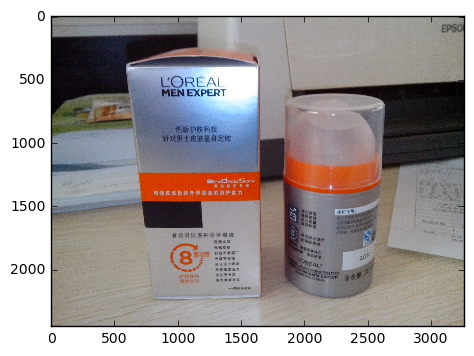

(300, 15)


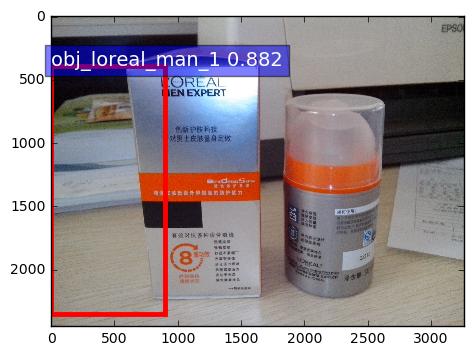

In [9]:
entry = roidb[1]
print entry['boxes']
im = cv2.imread(entry['im_path'])
plt.imshow(im[:,:,(2,1,0)])
plt.show()
scores, boxes = im_detect(net, im)
print scores.shape

CONF_THRESH = 0.8
NMS_THRESH = 0.3
for cls_ind, cls in enumerate(CLASSES[1:]):
    cls_ind += 1 # because we skipped background
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes,
                    cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(dets, NMS_THRESH)
    dets = dets[keep, :]
    vis_detections(im, cls, dets, thresh=CONF_THRESH)